# Model training

The input data is prepared by joining the calculated windfield with damaged values.
Subsampling is done by dropping those rows where the windspeed is 0, the the data stratification is done on damaged values.
The XGBoost Reduced Over fitting model, was trained on this prepared input data with gridcells.
The RMSE calculated in total and per each bin.

In [109]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [110]:
from utils import get_training_dataset

In [111]:
# df = get_training_dataset()
# df

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

In [113]:
# Read csv file and import to df

df = pd.read_csv("new_model_training_dataset.csv")
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,total_buildings,total_buildings_damaged,percent_buildings_damaged
0,DURIAN,2006,6262,0.0,57.0,0.0,0.0
1,DURIAN,2006,6264,0.0,379.0,0.0,0.0
2,DURIAN,2006,6265,0.0,23.0,0.0,0.0
3,DURIAN,2006,6428,0.0,156.0,0.0,0.0
4,DURIAN,2006,6429,0.0,90.0,0.0,0.0
...,...,...,...,...,...,...,...
106894,MOLAVE,2020,20554,0.0,173.0,0.0,0.0
106895,MOLAVE,2020,20555,0.0,44.0,0.0,0.0
106896,MOLAVE,2020,20556,0.0,13.0,0.0,0.0
106897,MOLAVE,2020,20557,0.0,401.0,0.0,0.0


array([[<AxesSubplot:title={'center':'percent_buildings_damaged'}>]],
      dtype=object)

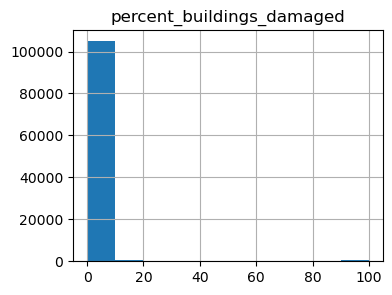

In [114]:
# Show histogram of damage
df.hist(column="percent_buildings_damaged", figsize=(4, 3))

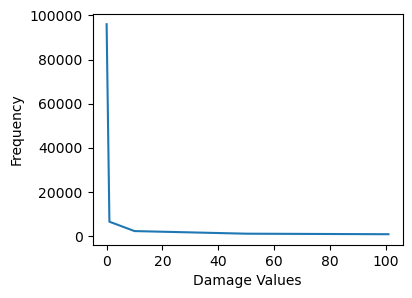

In [115]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [116]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]

df = df.drop(columns=["grid_point_id", "typhoon_year"])
df

,typhoon_name,wind_speed,total_buildings,total_buildings_damaged,percent_buildings_damaged
108,DURIAN,21.104601,126.0,0.0,0.0
109,DURIAN,19.968266,112.0,0.0,0.0
110,DURIAN,18.926342,8.0,0.0,0.0
127,DURIAN,25.354383,42.0,0.0,0.0
128,DURIAN,23.811114,455.0,0.0,0.0
...,...,...,...,...,...
106170,MOLAVE,18.406846,3.0,0.0,0.0
106338,MOLAVE,18.014052,1483.0,0.0,0.0
106381,MOLAVE,17.877636,5986.0,0.0,0.0
106428,MOLAVE,17.778820,646.0,0.0,0.0


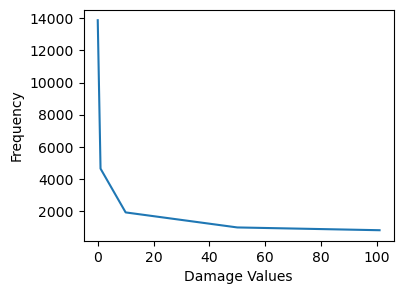

In [117]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [118]:
print(samples_per_bin2)
print(binsP2)

[13871  4647  1926   992   819]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [119]:
# Check the bins' intervalls
# df["percent_buildings_damaged"].value_counts(bins=binsP2)

In [120]:
bin_index2 = np.digitize(df["percent_buildings_damaged"], bins=binsP2)

In [121]:
y_input_strat = bin_index2

In [122]:
# Defin two lists to save total RMSE of test and train data
test_RMSE_list = []
train_RMSE_list = []

# Define empty lists for bins results(test and train)
test_RMSE_list_bin1 = []
test_RMSE_list_bin2 = []
test_RMSE_list_bin3 = []
test_RMSE_list_bin4 = []
test_RMSE_list_bin5 = []

train_RMSE_list_bin1 = []
train_RMSE_list_bin2 = []
train_RMSE_list_bin3 = []
train_RMSE_list_bin4 = []
train_RMSE_list_bin5 = []

In [123]:
features = [
    "wind_speed",
    "total_buildings",
    # "total_buildings_damaged"
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_buildings_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'total_buildings'], dtype='object')

In [125]:
# Run XGBoost Reduced Overfitting in for loop to estimate RMSE per bins

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, df["percent_buildings_damaged"], stratify=y_input_strat, test_size=0.2
    )

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=1,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_test, y_test)]
    xgb_model = xgb.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        # sample_weight=pow(y_train, 2),
    )

    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())

    X2_test = sm.add_constant(X_test)

    y_pred_train_LREG = est2.predict(X2)
    mse_train_idx_LREG = mean_squared_error(y_train, y_pred_train_LREG)
    rmse_train_LREG = np.sqrt(mse_train_idx_LREG)

    ypred_LREG = est2.predict(X2_test)
    mse_idx_LREG = mean_squared_error(y_test, ypred_LREG)
    rmse_LREG = np.sqrt(mse_idx_LREG)

    print("----- Training ------")
    print(f"LREG Root mean squared error: {rmse_train_LREG:.2f}")
    print("----- Test ------")
    print(f"LREG Root mean squared error: {rmse_LREG:.2f}")

    # Calculate RMSE in total

    y_pred_train = xgb.predict(X_train)
    mse_train_idx = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train_idx)

    y_pred = xgb.predict(X_test)
    mse_idx = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse_idx)

    print("----- Training ------")
    print(f"Root mean squared error: {rmse_train:.2f}")

    print("----- Test ------")
    print(f"Root mean squared error: {rmse:.2f}")

    test_RMSE_list.append(rmse)
    train_RMSE_list.append(rmse_train)

    # Calculate RMSE per bins

    bin_index_test = np.digitize(y_test, bins=binsP2)
    bin_index_train = np.digitize(y_train, bins=binsP2)

    # Estimation of RMSE for train data
    y_pred_train = xgb.predict(X_train)

    mse_train_idx1 = mean_squared_error(
        y_train[bin_index_train == 1], y_pred_train[bin_index_train == 1]
    )
    rmse_train_1 = np.sqrt(mse_train_idx1)
    mse_train_idx2 = mean_squared_error(
        y_train[bin_index_train == 2], y_pred_train[bin_index_train == 2]
    )
    rmse_train_2 = np.sqrt(mse_train_idx2)
    mse_train_idx3 = mean_squared_error(
        y_train[bin_index_train == 3], y_pred_train[bin_index_train == 3]
    )
    rmse_train_3 = np.sqrt(mse_train_idx3)
    mse_train_idx4 = mean_squared_error(
        y_train[bin_index_train == 4], y_pred_train[bin_index_train == 4]
    )
    rmse_train_4 = np.sqrt(mse_train_idx4)
    mse_train_idx5 = mean_squared_error(
        y_train[bin_index_train == 5], y_pred_train[bin_index_train == 5]
    )
    rmse_train_5 = np.sqrt(mse_train_idx5)

    # Estimation of RMSE for test data
    y_pred = xgb.predict(X_test)

    mse_idx1 = mean_squared_error(
        y_test[bin_index_test == 1], y_pred[bin_index_test == 1]
    )
    rmse_1 = np.sqrt(mse_idx1)
    mse_idx2 = mean_squared_error(
        y_test[bin_index_test == 2], y_pred[bin_index_test == 2]
    )
    rmse_2 = np.sqrt(mse_idx2)
    mse_idx3 = mean_squared_error(
        y_test[bin_index_test == 3], y_pred[bin_index_test == 3]
    )
    rmse_3 = np.sqrt(mse_idx3)
    mse_idx4 = mean_squared_error(
        y_test[bin_index_test == 4], y_pred[bin_index_test == 4]
    )
    rmse_4 = np.sqrt(mse_idx4)
    mse_idx5 = mean_squared_error(
        y_test[bin_index_test == 5], y_pred[bin_index_test == 5]
    )
    rmse_5 = np.sqrt(mse_idx5)

    train_RMSE_list_bin1.append(rmse_train_1)
    train_RMSE_list_bin2.append(rmse_train_2)
    train_RMSE_list_bin3.append(rmse_train_3)
    train_RMSE_list_bin4.append(rmse_train_4)
    train_RMSE_list_bin5.append(rmse_train_5)

    test_RMSE_list_bin1.append(rmse_1)
    test_RMSE_list_bin2.append(rmse_2)
    test_RMSE_list_bin3.append(rmse_3)
    test_RMSE_list_bin4.append(rmse_4)
    test_RMSE_list_bin5.append(rmse_5)

[10:36:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                                OLS Regression Results                               
Dep. Variable:     percent_buildings_damaged   R-squared:                       0.139
Model:                                   OLS   Adj. R-squared:                  0.139
Method:                        Least Squares   F-statistic:                     1438.
Date:                       Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                               10:36:29   Log-Likelihood:                -75123.
No. Observations:                      17804   

# Plot RMSE in total

stdev_RMSE_test: 0.26
stdev_RMSE_train: 0.08
mean_RMSE_test: 15.35
mean_RMSE_train: 14.37


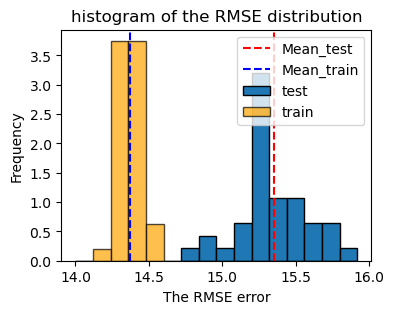

In [126]:
# RMSE in total

m_test_rmse = statistics.mean(test_RMSE_list)
plt.figure(figsize=(4, 3))
plt.axvline(m_test_rmse, color="red", linestyle="dashed")
plt.hist(
    test_RMSE_list,
    bins=np.arange(14.0, 16.0, 0.12),
    edgecolor="k",
    histtype="bar",
    density=True,
)
sd_test_rmse = statistics.stdev(test_RMSE_list)


m_train_rmse = statistics.mean(train_RMSE_list)
plt.axvline(m_train_rmse, color="b", linestyle="dashed")
plt.hist(
    train_RMSE_list,
    bins=np.arange(14.0, 16.0, 0.12),
    color="orange",
    edgecolor="k",
    histtype="bar",
    density=True,
    alpha=0.7,
)
sd_train_rmse = statistics.stdev(train_RMSE_list)

print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

print(f"mean_RMSE_test: {m_test_rmse:.2f}")
print(f"mean_RMSE_train: {m_train_rmse:.2f}")

# create legend
labels = ["Mean_test", "Mean_train", "test", "train"]
plt.legend(labels)

plt.xlabel("The RMSE error")
plt.ylabel("Frequency")
plt.title("histogram of the RMSE distribution")
plt.show()

# Plot RMSE per bins

stdev_RMSE_test: 0.17
stdev_RMSE_train: 0.05
mean_RMSE_test: 5.09
mean_RMSE_train: 4.90


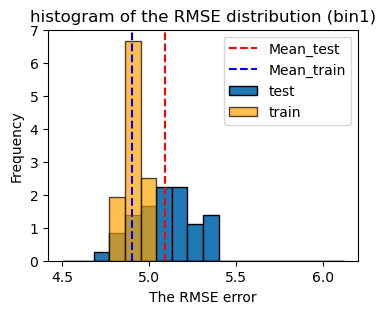

In [127]:
# RMSE of bins_1

m_test_rmse = statistics.mean(test_RMSE_list_bin1)
plt.figure(figsize=(4, 3))
plt.axvline(m_test_rmse, color="red", linestyle="dashed")
plt.hist(
    test_RMSE_list_bin1,
    bins=np.arange(4.5, 6.2, 0.09),
    edgecolor="k",
    histtype="bar",
    density=True,
)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin1)


m_train_rmse = statistics.mean(train_RMSE_list_bin1)
plt.axvline(m_train_rmse, color="b", linestyle="dashed")
plt.hist(
    train_RMSE_list_bin1,
    bins=np.arange(4.5, 6.2, 0.09),
    color="orange",
    edgecolor="k",
    histtype="bar",
    density=True,
    alpha=0.7,
)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin1)

print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

print(f"mean_RMSE_test: {m_test_rmse:.2f}")
print(f"mean_RMSE_train: {m_train_rmse:.2f}")

# create legend
labels = ["Mean_test", "Mean_train", "test", "train"]
plt.legend(labels)

plt.xlabel("The RMSE error")
plt.ylabel("Frequency")
plt.title("histogram of the RMSE distribution (bin1)")
plt.show()

stdev_RMSE_test: 0.39
stdev_RMSE_train: 0.11
mean_RMSE_test: 8.34
mean_RMSE_train: 7.72


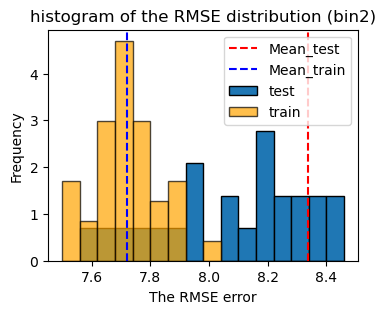

In [128]:
# RMSE of bins_2

m_test_rmse = statistics.mean(test_RMSE_list_bin2)
plt.figure(figsize=(4, 3))
plt.axvline(m_test_rmse, color="red", linestyle="dashed")
plt.hist(
    test_RMSE_list_bin2,
    bins=np.arange(7.5, 8.5, 0.06),
    edgecolor="k",
    histtype="bar",
    density=True,
)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin2)


m_train_rmse = statistics.mean(train_RMSE_list_bin2)
plt.axvline(m_train_rmse, color="b", linestyle="dashed")
plt.hist(
    train_RMSE_list_bin2,
    bins=np.arange(7.5, 8.5, 0.06),
    color="orange",
    edgecolor="k",
    histtype="bar",
    density=True,
    alpha=0.7,
)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin2)

print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

print(f"mean_RMSE_test: {m_test_rmse:.2f}")
print(f"mean_RMSE_train: {m_train_rmse:.2f}")

# create legend
labels = ["Mean_test", "Mean_train", "test", "train"]
plt.legend(labels)

plt.xlabel("The RMSE error")
plt.ylabel("Frequency")
plt.title("histogram of the RMSE distribution (bin2)")
plt.show()

stdev_RMSE_test: 0.64
stdev_RMSE_train: 0.16
mean_RMSE_test: 11.42
mean_RMSE_train: 10.47


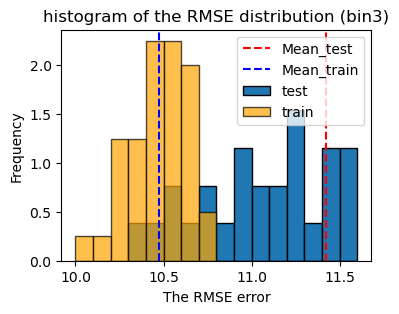

In [129]:
# RMSE of bins_3

m_test_rmse = statistics.mean(test_RMSE_list_bin3)
plt.figure(figsize=(4, 3))
plt.axvline(m_test_rmse, color="red", linestyle="dashed")
plt.hist(
    test_RMSE_list_bin3,
    bins=np.arange(10.0, 11.7, 0.1),
    edgecolor="k",
    histtype="bar",
    density=True,
)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin3)


m_train_rmse = statistics.mean(train_RMSE_list_bin3)
plt.axvline(m_train_rmse, color="b", linestyle="dashed")
plt.hist(
    train_RMSE_list_bin3,
    bins=np.arange(10.0, 11.7, 0.1),
    color="orange",
    edgecolor="k",
    histtype="bar",
    density=True,
    alpha=0.7,
)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin3)

print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

print(f"mean_RMSE_test: {m_test_rmse:.2f}")
print(f"mean_RMSE_train: {m_train_rmse:.2f}")

# create legend
labels = ["Mean_test", "Mean_train", "test", "train"]
plt.legend(labels)

plt.xlabel("The RMSE error")
plt.ylabel("Frequency")
plt.title("histogram of the RMSE distribution (bin3)")
plt.show()

stdev_RMSE_test: 0.89
stdev_RMSE_train: 0.24
mean_RMSE_test: 17.16
mean_RMSE_train: 16.43


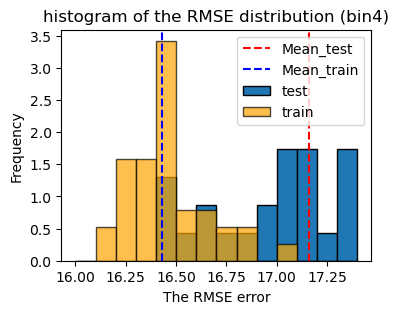

In [130]:
# RMSE of bins_4

m_test_rmse = statistics.mean(test_RMSE_list_bin4)
plt.figure(figsize=(4, 3))
plt.axvline(m_test_rmse, color="red", linestyle="dashed")
plt.hist(
    test_RMSE_list_bin4,
    bins=np.arange(16.0, 17.5, 0.1),
    edgecolor="k",
    histtype="bar",
    density=True,
)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin4)


m_train_rmse = statistics.mean(train_RMSE_list_bin4)
plt.axvline(m_train_rmse, color="b", linestyle="dashed")
plt.hist(
    train_RMSE_list_bin4,
    bins=np.arange(16.0, 17.5, 0.1),
    color="orange",
    edgecolor="k",
    histtype="bar",
    density=True,
    alpha=0.7,
)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin4)

print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

print(f"mean_RMSE_test: {m_test_rmse:.2f}")
print(f"mean_RMSE_train: {m_train_rmse:.2f}")

# create legend
labels = ["Mean_test", "Mean_train", "test", "train"]
plt.legend(labels)

plt.xlabel("The RMSE error")
plt.ylabel("Frequency")
plt.title("histogram of the RMSE distribution (bin4)")
plt.show()

stdev_RMSE_test: 1.34
stdev_RMSE_train: 0.40
mean_RMSE_test: 69.99
mean_RMSE_train: 65.44


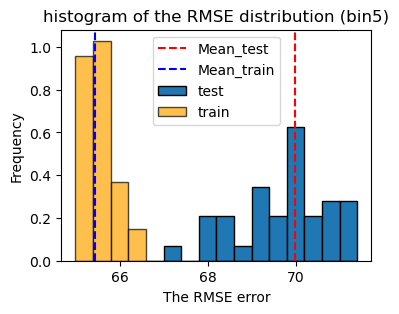

In [131]:
# RMSE of bins_5

m_test_rmse = statistics.mean(test_RMSE_list_bin5)
plt.figure(figsize=(4, 3))
plt.axvline(m_test_rmse, color="red", linestyle="dashed")
plt.hist(
    test_RMSE_list_bin5,
    bins=np.arange(65.0, 71.5, 0.4),
    edgecolor="k",
    histtype="bar",
    density=True,
)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin5)


m_train_rmse = statistics.mean(train_RMSE_list_bin5)
plt.axvline(m_train_rmse, color="b", linestyle="dashed")
plt.hist(
    train_RMSE_list_bin5,
    bins=np.arange(65.0, 71.5, 0.4),
    color="orange",
    edgecolor="k",
    histtype="bar",
    density=True,
    alpha=0.7,
)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin5)

print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

print(f"mean_RMSE_test: {m_test_rmse:.2f}")
print(f"mean_RMSE_train: {m_train_rmse:.2f}")

# create legend
labels = ["Mean_test", "Mean_train", "test", "train"]
plt.legend(labels)

plt.xlabel("The RMSE error")
plt.ylabel("Frequency")
plt.title("histogram of the RMSE distribution (bin5)")
plt.show()